In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans,MeanShift,estimate_bandwidth,DBSCAN
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,RobustScaler
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle

from warnings import filterwarnings
filterwarnings('ignore')

In [13]:
data = pd.read_csv('data_all.csv')
data.head()

,residue name,position,chain,phi,psi
0,LYS,10,A,-149.312855,142.657714
1,PRO,11,A,-44.283210,136.002076
2,LYS,12,A,-119.972621,-168.705263
3,LEU,13,A,-135.317212,137.143523
4,LEU,14,A,-104.851467,95.928520


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29369 entries, 0 to 29368
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   residue name  29369 non-null  object 
 1   position      29369 non-null  int64  
 2   chain         29369 non-null  object 
 3   phi           29369 non-null  float64
 4   psi           29369 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.1+ MB


In [15]:
data[["phi","psi"]].describe().T

,count,mean,std,min,25%,50%,75%,max
phi,29369.0,-82.362440,56.848421,-179.991175,-118.089883,-85.198070,-63.287290,179.973856
psi,29369.0,64.251961,91.119597,-179.995255,-24.299401,110.903019,141.154709,179.986259


In [16]:
data.isnull().sum()

residue name    0
position        0
chain           0
phi             0
psi             0
dtype: int64

## Continuous Feature Analysis 
* Correlation matrix for numeric features

In [ ]:
numericVar = ["phi","psi"]
corrmat = data[numericVar].corr(method="pearson") 
plt.subplots(figsize=(10,6))
sns.heatmap(corrmat, annot=True, vmax=1, square=True);

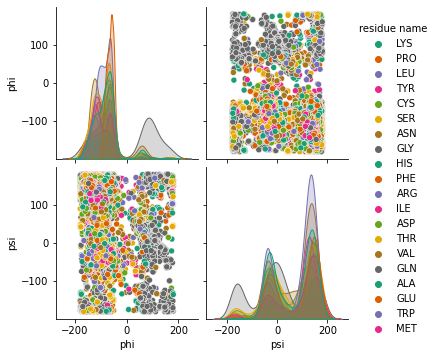

In [88]:
sns.pairplot(data=data,vars=["phi","psi"],kind='scatter',hue="residue name",palette='Dark2');

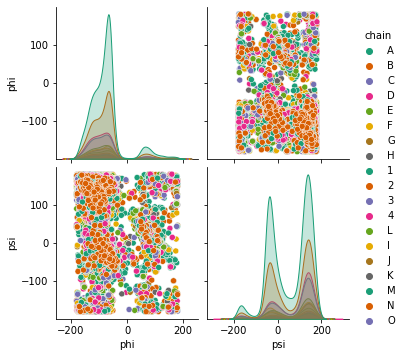

In [89]:
sns.pairplot(data=data,vars=["phi","psi"],kind='scatter',hue="chain",palette='Dark2');

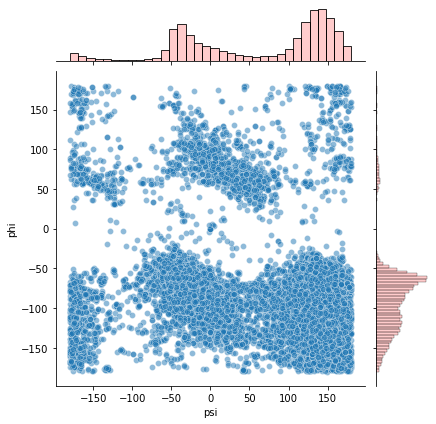

In [90]:
sns.jointplot(data.psi, data.phi,
                 cmap="Reds", kind="scatter", marginal_kws={"color":"r", "alpha":.2},alpha=.5,palette="Dark2");

## Categorical Variable Analysis

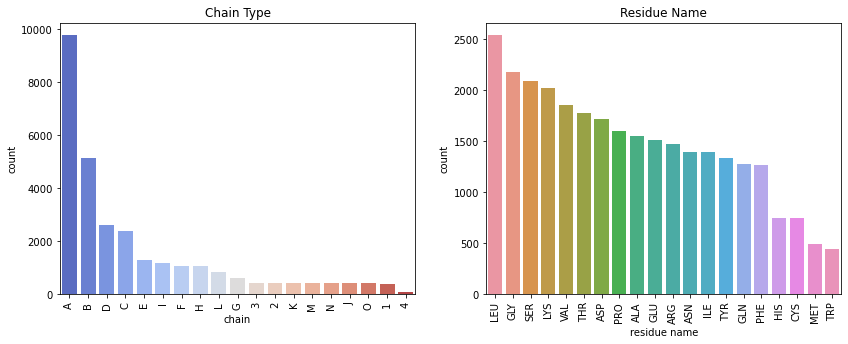

In [22]:
f,ax=plt.subplots(1,2,figsize=(14,5))
sns.countplot(x=data["chain"],order= data["chain"].value_counts().index,ax=ax[0],palette="coolwarm") 
ax[0].set_title('Chain Type')
ax[0].tick_params(axis='x', rotation=90)
sns.countplot(x=data["residue name"],order= data["residue name"].value_counts().index,ax=ax[1])
ax[1].set_title('Residue Name')
ax[1].tick_params(axis='x', rotation=90)

## 2. Use the K-means clustering method to cluster the phi and psi angle combinations in the data file.

### a. Experiment with different values of K. Suggest an appropriate value of K for this task and motivate this choice.

In [17]:
data_model=data[["psi","phi"]]

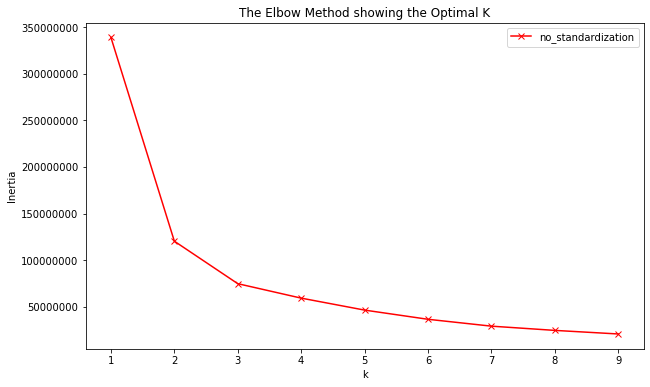

In [93]:
distortions_without_standardization = []
k_number = range(1,10)
for k in k_number:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data_model)
    distortions_without_standardization.append(km.inertia_)    

plt.figure(figsize=(10,6))
plt.plot(k_number, distortions_without_standardization, 'rx-',label='no_standardization')
plt.legend()
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the Optimal K')
plt.ticklabel_format(style='plain')
plt.show()

In [94]:
for n_clusters in [2,3,4,5]:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(data_model)

    score = silhouette_score(data_model, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.6328209708884562)
For n_clusters = 3, silhouette score is 0.6724895253169637)
For n_clusters = 4, silhouette score is 0.6674392423283723)
For n_clusters = 5, silhouette score is 0.5095422938273266)


In [18]:
km = KMeans(n_clusters=3, random_state=42)
labels_kmeans = km.fit_predict(data_model)
labels_kmeans

array([1, 1, 2, ..., 1, 2, 1])

In [19]:
data['Cluster_NonNormalized'] = labels_kmeans
data.head(10)

,residue name,position,chain,phi,psi,Cluster_NonNormalized
0,LYS,10,A,-149.312855,142.657714,1
1,PRO,11,A,-44.283210,136.002076,1
2,LYS,12,A,-119.972621,-168.705263,2
3,LEU,13,A,-135.317212,137.143523,1
4,LEU,14,A,-104.851467,95.928520,1
5,TYR,15,A,-91.504388,123.866914,1
6,CYS,16,A,-93.197858,118.520749,1
7,SER,17,A,-47.624937,-52.194897,2
8,ASN,18,A,-64.047729,105.183729,1
9,GLY,19,A,93.478288,-26.252796,0


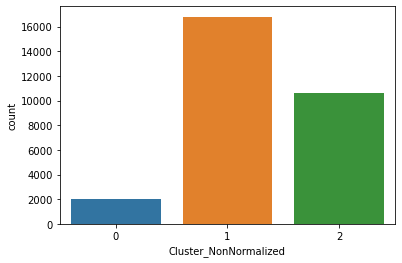

In [98]:
sns.countplot(data.Cluster_NonNormalized);

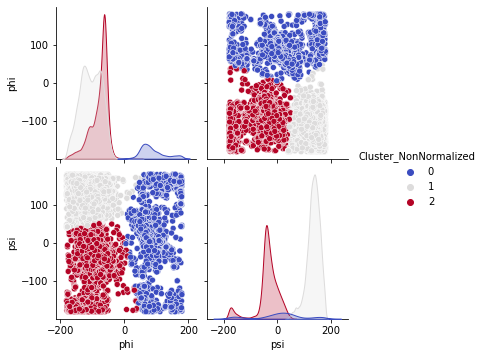

In [100]:
data_temp = data.loc[:,['Cluster_NonNormalized','phi','psi']]
sns.pairplot(data_temp, hue="Cluster_NonNormalized",palette="coolwarm");

In [20]:
temp = pd.crosstab(data.Cluster_NonNormalized, data["residue name"], rownames = ['Cluster_NonNormalized'])
temp

residue name,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
Cluster_NonNormalized,,,,,,,,,,,,,,,,,,,,
0,44,38,217,87,2,24,49,1159,66,14,26,117,6,3,2,65,15,8,18,29
1,841,832,714,859,531,783,681,488,388,931,1719,1096,262,963,978,1060,1022,301,924,1422
2,663,601,463,774,209,466,778,529,291,445,788,808,224,300,616,964,738,133,396,399


### 2- d. Can you change the data to get better results (or the same results in a simpler way)?

In [25]:
data_model=data[["psi","phi"]]

In [26]:
stscaler = StandardScaler()
robust = RobustScaler()

data_model_standard = pd.DataFrame(stscaler.fit_transform(data_model), columns=data_model.columns)
data_model_robust = pd.DataFrame(robust.fit_transform(data_model), columns=data_model.columns)

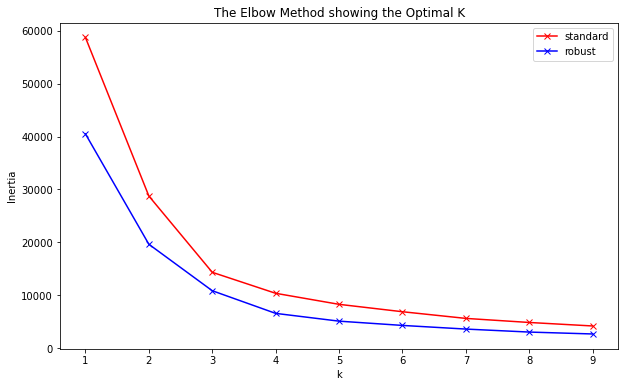

In [104]:
distortions_robust = []
distortions_standard = []
k_number = range(1,10)
for k in k_number:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data_model_robust)
    distortions_robust.append(km.inertia_)    
    km.fit(data_model_standard)
    distortions_standard.append(km.inertia_)


plt.figure(figsize=(10,6))
plt.plot(k_number, distortions_standard, 'rx-',label='standard')
plt.plot(k_number, distortions_robust, 'bx-',label='robust')
plt.legend()
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the Optimal K')
plt.show()

In [105]:
#data_model = data_model_robust.copy()
print('Robust')
for n_clusters in [2,3,4,5,6]:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(data_model_robust)

    score = silhouette_score(data_model, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
print('Standard')
for n_clusters in [2,3,4,5,6]:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(data_model_standard)

    score = silhouette_score(data_model_standard, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score)) 

Robust
For n_clusters = 2, silhouette score is 0.48573907393402593)
For n_clusters = 3, silhouette score is 0.6282752167950407)
For n_clusters = 4, silhouette score is 0.46146150468771174)
For n_clusters = 5, silhouette score is 0.4248127868854812)
For n_clusters = 6, silhouette score is 0.35441473169936677)
Standard
For n_clusters = 2, silhouette score is 0.5558994070715864)
For n_clusters = 3, silhouette score is 0.6166516786268311)
For n_clusters = 4, silhouette score is 0.5317152119760037)
For n_clusters = 5, silhouette score is 0.5408242841986257)
For n_clusters = 6, silhouette score is 0.5378980957427691)


In [27]:
km = KMeans(n_clusters=3, random_state=42)
labels_kmeans_modified = km.fit_predict(data_model_robust)
labels_kmeans_modified

array([1, 1, 0, ..., 1, 0, 1])

In [28]:
data['Cluster_RobustScaled'] = labels_kmeans_modified
data.head(10)

,residue name,position,chain,phi,psi,Cluster_NonNormalized,Cluster_RobustScaled
0,LYS,10,A,-149.312855,142.657714,1,1
1,PRO,11,A,-44.283210,136.002076,1,1
2,LYS,12,A,-119.972621,-168.705263,2,0
3,LEU,13,A,-135.317212,137.143523,1,1
4,LEU,14,A,-104.851467,95.928520,1,1
5,TYR,15,A,-91.504388,123.866914,1,1
6,CYS,16,A,-93.197858,118.520749,1,1
7,SER,17,A,-47.624937,-52.194897,2,0
8,ASN,18,A,-64.047729,105.183729,1,1
9,GLY,19,A,93.478288,-26.252796,0,2


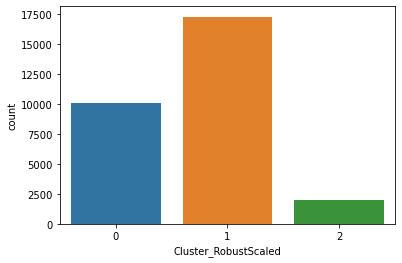

In [29]:
sns.countplot(data.Cluster_RobustScaled);

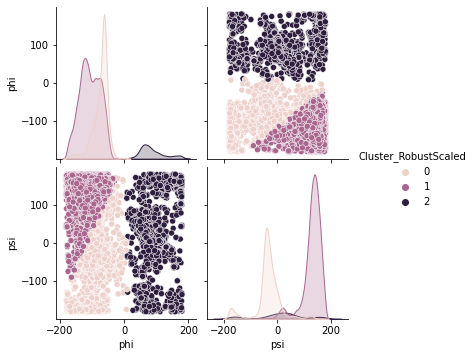

In [109]:
data_temp = data.loc[:,['Cluster_RobustScaled','phi','psi']]
sns.pairplot(data_temp, hue="Cluster_RobustScaled");

In [110]:
temp2 = pd.crosstab(data.Cluster_RobustScaled, data["residue name"], rownames = ['Cluster_RobustScaled'],colnames=["chain"])
temp2

chain,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
Cluster_RobustScaled,,,,,,,,,,,,,,,,,,,,
0,647,570,433,761,165,465,762,478,253,415,783,785,212,268,679,886,652,128,341,423
1,856,860,747,871,575,784,690,533,426,961,1724,1119,274,995,914,1137,1108,306,976,1397
2,45,41,214,88,2,24,56,1165,66,14,26,117,6,3,3,66,15,8,21,30


## 2-d (con't). MeanShift Clustering

In [111]:
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using the code.
bandwidth = estimate_bandwidth(data_model, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit_predict(data_model)
cluster_centers = ms.cluster_centers_
labels = ms.labels_

In [112]:
labels_unique_meanshift = np.unique(labels)
n_clusters_ = len(labels_unique_meanshift)

print("Number of estimated clusters : %d" % n_clusters_)

Number of estimated clusters : 8


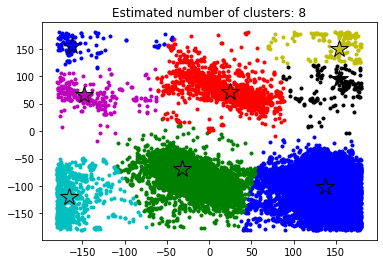

In [113]:
data_values=data_model.values
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(data_values[my_members, 0], data_values[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], '*', markerfacecolor=col,
             markeredgecolor='k', markersize=18)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

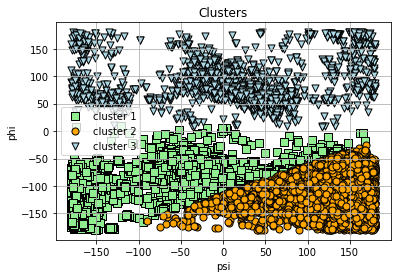

In [54]:
# plot the 3 clusters
data_model_values = data_model.values
plt.scatter(
    data_model_values[labels_kmeans_modified == 0, 0], data_model_values[labels_kmeans_modified == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    data_model_values[labels_kmeans_modified == 1, 0], data_model_values[labels_kmeans_modified == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    data_model_values[labels_kmeans_modified == 2, 0], data_model_values[labels_kmeans_modified == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
#plt.scatter(
#    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
#    s=250, marker='*',
#    c='red', edgecolor='black',
#    label='centroids'
#)


plt.legend(scatterpoints=1)
plt.grid()
plt.xlabel("psi")
plt.ylabel("phi")
plt.title("Clusters")
plt.show()

## 3. Use the DBSCAN method to cluster the phi and psi angle combinations in the data file.

In [114]:
data_model.head()

,psi,phi
0,142.657714,-149.312855
1,136.002076,-44.283210
2,-168.705263,-119.972621
3,137.143523,-135.317212
4,95.928520,-104.851467


In [135]:
db = DBSCAN(eps=0.3, min_samples=10).fit(data_model)
y_pred = db.fit_predict(data_model)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 7
Estimated number of noise points: 29280


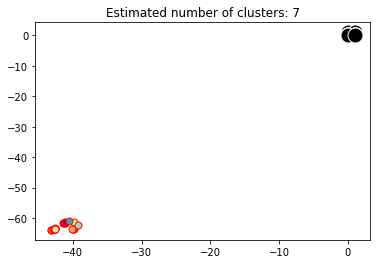

In [136]:
unique_labels = set(labels)
data_values=data_model.values
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data_values[class_member_mask & ~core_samples_mask] >0
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='w', markersize=15,c=y_pred)

    xy = data_values[class_member_mask & core_samples_mask] # Black used for noise.
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='r', markersize=7)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [137]:
clusters=pd.DataFrame(db.labels_,columns=['clusters'])
clusters.value_counts()
#-1 cluster represents outliers which means we have 29280 data points as outliers

clusters
-1          29280
 0             19
 2             15
 3             13
 6             11
 1             11
 5             10
 4             10
dtype: int64

In [138]:
data_rest = data[["residue name","position","chain"]]

In [139]:
#-1 cluster represents outliers which means we have 29322 data points as outliers
final_data=pd.concat([clusters,data_model],axis=1)
final_data_last =pd.concat([data_rest,final_data],axis=1)
final_data_last.head()

,residue name,position,chain,clusters,psi,phi
0,LYS,10,A,-1,142.657714,-149.312855
1,PRO,11,A,-1,136.002076,-44.283210
2,LYS,12,A,-1,-168.705263,-119.972621
3,LEU,13,A,-1,137.143523,-135.317212
4,LEU,14,A,-1,95.928520,-104.851467


In [140]:
final_data_last_filtered = final_data_last[(final_data_last['clusters']== -1)]
final_data_last_filtered.head()

,residue name,position,chain,clusters,psi,phi
0,LYS,10,A,-1,142.657714,-149.312855
1,PRO,11,A,-1,136.002076,-44.283210
2,LYS,12,A,-1,-168.705263,-119.972621
3,LEU,13,A,-1,137.143523,-135.317212
4,LEU,14,A,-1,95.928520,-104.851467


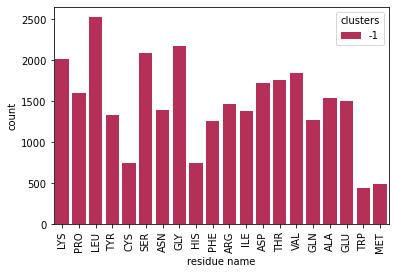

In [141]:
sns.countplot("residue name",data=final_data_last_filtered,hue="clusters",palette='rocket_r');
plt.xticks(rotation=90)
plt.show();

## 4. The data file can be stratified by amino acid residue type.
### a. Use DBSCAN to cluster the data that have residue type PRO. Investigate how the clusters found for amino acid residues of type PRO differ from the general clusters

In [167]:
data= pd.read_csv("data_all.csv")
data_filtered_pro = data[data["residue name"] == "PRO"]
data_filtered_pro.head()

,residue name,position,chain,phi,psi
1,PRO,11,A,-44.283210,136.002076
17,PRO,27,A,-49.944645,-25.888991
68,PRO,79,A,-76.452014,97.745207
110,PRO,121,A,-53.054020,-27.254912
123,PRO,134,A,-66.751364,94.099782


In [168]:
data_filtered_pro_phi_psi = data_filtered_pro[["phi","psi"]]
data_filtered_pro_phi_psi.head()

,phi,psi
1,-44.283210,136.002076
17,-49.944645,-25.888991
68,-76.452014,97.745207
110,-53.054020,-27.254912
123,-66.751364,94.099782


In [183]:
db = DBSCAN(eps=1, min_samples=5).fit(data_filtered_pro_phi_psi)
y_pred = db.fit_predict(data_filtered_pro_phi_psi)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 34
Estimated number of noise points: 1339


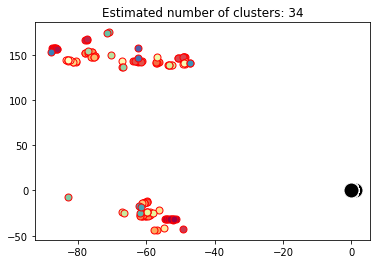

In [184]:
unique_labels = set(labels)
data_values=data_filtered_pro_phi_psi.values
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data_values[class_member_mask & ~core_samples_mask] >0
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='w', markersize=15,c=y_pred)

    xy = data_values[class_member_mask & core_samples_mask] # Black used for noise.
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='r', markersize=7)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## b. Now use DBSCAN to cluster the data that have residue type GLY. Investigate how the clusters found for amino acid residues of type GLY differ from the general clusters.

In [145]:
data_filtered_gly = data[data["residue name"] == "GLY"]
data_filtered_gly.head()

,residue name,position,chain,phi,psi
9,GLY,19,A,93.478288,-26.252796
10,GLY,20,A,65.608117,55.368614
19,GLY,29,A,72.426939,7.659478
23,GLY,33,A,-140.433679,159.800231
42,GLY,52,A,-122.469112,-4.890135


In [146]:
data_filtered_gly_phi_psi = data_filtered_gly[["phi","psi"]]
data_filtered_gly_phi_psi.head()

,phi,psi
9,93.478288,-26.252796
10,65.608117,55.368614
19,72.426939,7.659478
23,-140.433679,159.800231
42,-122.469112,-4.890135


In [150]:
db = DBSCAN(eps=1, min_samples=5).fit(data_filtered_gly_phi_psi)
y_pred = db.fit_predict(data_filtered_gly_phi_psi)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 12
Estimated number of noise points: 2115


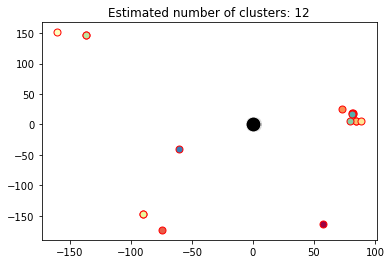

In [152]:
unique_labels = set(labels)
data_values=data_filtered_gly_phi_psi.values
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data_values[class_member_mask & ~core_samples_mask] >0
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='w', markersize=15,c=y_pred)

    xy = data_values[class_member_mask & core_samples_mask] # Black used for noise.
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='r', markersize=7)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()